In [1]:
import os
from glob import glob
from dataset import (
    MultipleSequenceGraphDataset,
    SequenceGraphDataset,
    KittiSequenceDataset,
    FourSeasonsSequenceDataset,
)
from torch_geometric.loader import DataLoader
from scipy.spatial.transform import Rotation as R
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
os.makedirs("models", exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda


In [3]:
basedir_kitti = "/home/pcktm/inzynierka/kitti/dataset"
train_sequences_kitti = ["00", "01", "02", "03", "04", "05", "06", "07", "08"]

basedir_4seasons = "/home/pcktm/inzynierka/4seasons"
train_sequences_4se = ["office_loop_3", "neighboorhood_6"]

In [4]:
from torch_geometric.utils import dropout_edge, dropout_node


def normalize_position_to_first_and_dropout(nodes, edge_index, y):
    positions = torch.stack([s[:3] for s in y])

    # edge_index, _, _ = dropout_node(edge_index, p=0.4, num_nodes=positions.shape[0])

    # normalize position of each frame to the first frame
    new_pos = []
    for i in range(positions.shape[0]):
        new_pos.append(positions[i] - positions[0])
    new_pos = torch.stack(new_pos)

    edge_index, _ = dropout_edge(edge_index, p=0.4)

    return nodes, edge_index, new_pos

In [5]:
from model import PoseGNN, PoseLoss, JustLastNodePositionLoss

BATCH_SIZE = 128
GRAPH_LENGTH = 6

four_seasons_sequences = [
    FourSeasonsSequenceDataset(basedir_4seasons, sequence_name, "features_4se_bitm")
    for sequence_name in train_sequences_4se
]

kitti_sequences = [
    KittiSequenceDataset(basedir_kitti, sequence_name, "features_kitti_bitm")
    for sequence_name in train_sequences_kitti
]

dataset = MultipleSequenceGraphDataset(
    four_seasons_sequences + kitti_sequences,
    graph_length=GRAPH_LENGTH,
    transform=normalize_position_to_first_and_dropout,
)
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = SequenceGraphDataset(
    KittiSequenceDataset(basedir_kitti, "09", "features_kitti_bitm"),
    graph_length=GRAPH_LENGTH,
    transform=normalize_position_to_first_and_dropout,
)
validation_dataloader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, shuffle=True
)

model = PoseGNN().to(device)

criterion = JustLastNodePositionLoss(
    graph_length=GRAPH_LENGTH, batch_size=BATCH_SIZE
).to(device)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (833980467.py, line 17)

In [6]:
optimizer = torch.optim.AdamW(model.parameters())
MODEL_LETTER = "BTIM_A_GATv2Conv_4seasons"

os.makedirs(f"models/{MODEL_LETTER}", exist_ok=True)

# drop all model training parameters to a file
with open(f"models/{MODEL_LETTER}/params.txt", "w") as f:
    f.write(f"batch_size: {BATCH_SIZE}\n")
    f.write(f"graph_length: {GRAPH_LENGTH}\n")
    f.write(f"model: {model}\n")
    f.write(f"criterion: {criterion}\n")
    f.write(f"optimizer: {optimizer}\n")

loss_history = []
for epoch in range(1, 100):
    model.train()
    epoch_loss_history = []
    progress_bar = tqdm(
        train_dataloader, desc=f"Epoch {epoch}", total=len(train_dataloader)
    )
    for batch in progress_bar:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch.y)
        loss.backward()
        optimizer.step()
        epoch_loss_history.append(loss.item())
        progress_bar.set_postfix({"loss": loss.item()})

    # evaluate model on the validation set
    model.eval()
    validation_loss_history = []
    with torch.no_grad():
        for batch in tqdm(
            validation_dataloader, desc="Validation", total=len(validation_dataloader)
        ):
            batch = batch.to(device)
            output = model(batch)
            loss = criterion(output, batch.y)
            validation_loss_history.append(loss.item())

    loss_history.append(sum(epoch_loss_history) / len(epoch_loss_history))
    print(
        f"Epoch {epoch} loss: {sum(epoch_loss_history) / len(epoch_loss_history):.3f} validation loss: {sum(validation_loss_history) / len(validation_loss_history):.3f}"
    )

    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"models/{MODEL_LETTER}/model_{epoch}.pth")
        print("Model saved")

torch.save(model.state_dict(), f"models/{MODEL_LETTER}/model_final.pth")

Epoch 1:   0%|          | 0/58 [00:00<?, ?it/s]

Validation: 100%|██████████| 13/13 [00:00<00:00, 16.28it/s]


Epoch 1 loss: 9.134 validation loss: 24.618


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.34it/s]


Epoch 2 loss: 5.466 validation loss: 19.938


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.28it/s]


Epoch 3 loss: 3.664 validation loss: 20.139


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.89it/s]


Epoch 4 loss: 2.181 validation loss: 19.511


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.66it/s]


Epoch 5 loss: 1.800 validation loss: 18.085


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.02it/s]


Epoch 6 loss: 1.252 validation loss: 17.220


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.89it/s]


Epoch 7 loss: 0.909 validation loss: 18.270


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.59it/s]


Epoch 8 loss: 0.711 validation loss: 18.216


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.51it/s]


Epoch 9 loss: 0.581 validation loss: 17.582


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.15it/s]


Epoch 10 loss: 0.535 validation loss: 17.822
Model saved


Epoch 11:  86%|████████▌ | 50/58 [00:03<00:00, 15.61it/s, loss=0.561]


KeyboardInterrupt: 

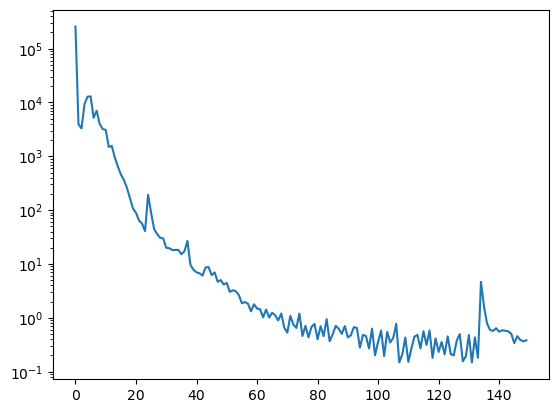

In [12]:
# plot loss
plt.plot(loss_history)#log
plt.yscale("log")
plt.show()